In [4]:
# Import dependencies
from pytorch_forecasting.data.examples import get_stallion_data
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [5]:
# load data as pandas dataframe
data = get_stallion_data()  

# Data preprocesing

In [6]:
# Make sur each row can be identified with a time step and a time series.
# add time index that is incremented by one for each time step.
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# Add additional features
# categories have to be strings
data["month"] = data["date"].dt.month.astype(str).astype("category")
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = (data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean"))
data["avg_volume_by_agency"] = (data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean"))

# Encode special days as unique identifier 
# first reverse one-hot encoding
special_days = [
    "easter_day", "good_friday", "new_year", "christmas",
    "labor_day", "independence_day", "revolution_day_memorial",
    "regional_games", "fifa_u_17_world_cup", "football_gold_cup",
    "beer_capital", "music_fest"
]
data[special_days] = (
    data[special_days]
    .apply(lambda x: x.map({0: "-", 1: x.name}))
    .astype("category")
)


In [7]:
# Sample data preview
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [8]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


# Create dataset and dataloaders

In [9]:
# use the last six months as a validation set, and compare to forcast result
max_prediction_length = 6  # forecast 6 months
max_encoder_length = 24  # use 24 months of history
training_cutoff = data["time_idx"].max() - max_prediction_length

# Normalize data: scale each time series separately and indicate that values are always positive
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer

In [10]:
# Create training set
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=0,  # allow predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=[
        "avg_population_2017",
        "avg_yearly_household_income_2017"
    ],
    time_varying_known_categoricals=["special_days", "month"],
    # group of categorical variables can be treated as 
    # one variable --> special days' list
    variable_groups={"special_days": special_days},
    time_varying_known_reals=[
        "time_idx",
        "price_regular",
        "discount_in_percent"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], coerce_positive=1.0
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
)

In [11]:
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

In [12]:
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

# Create Baseline Model as benchmark

In [26]:
import torch
from pytorch_forecasting import Baseline

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()


293.0088195800781

# Find optimal learning rate

In [15]:
import pytorch_lightning as pl
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

In [16]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,# not meaningful for finding the learning rate but otherwise very important
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)


GPU available: True, used: False
TPU available: False, using: 0 TPU cores


In [17]:
# Number of parameters in network
tft.size() 

29625


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | input_embeddings                   | ModuleDict                      | 1 K   
2  | prescalers                         | ModuleDict                      | 256   
3  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
4  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
5  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
6  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
7  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
8  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K   
9  | static_context_enrichment          | GatedResidualNetwork            | 1 K 

Saving latest checkpoint..
LR finder stopped early due to diverging loss.


suggested learning rate: 0.15135612484362077


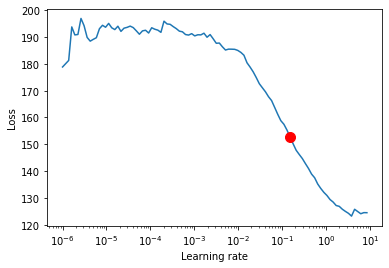

In [18]:
res = trainer.lr_find(
    tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, max_lr=10., min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

#### Optimal learning is lower than suggested learning rate, so learning rate used will be mark down a little bit, 0.03

# Training the Temporal Fusion Transformer with PyTorch Lightning

In [19]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateLogger
from pytorch_lightning.loggers import TensorBoardLogger

In [20]:
# Halt training when loss metric does not improve on validation set
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min"
)

#Log data
lr_logger = LearningRateLogger()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # log result to tensorboard

# create trainer using PyTorch Lightning
trainer = pl.Trainer(
    max_epochs=30,
    gpus=[0],  # 0 to train on CPU whereas [0] for GPU
    gradient_clip_val=0.1,
    early_stop_callback=early_stop_callback,
    limit_train_batches=30,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    callbacks=[lr_logger],
    logger=logger,
)

# initialise model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [21]:
# Number of parameters in network
tft.size() 

29625

In [22]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | input_embeddings                   | ModuleDict                      | 1 K   
2  | prescalers                         | ModuleDict                      | 256   
3  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
4  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
5  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
6  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
7  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
8  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K   
9  | static_context_enrichment          | GatedResidualNetwork            | 1 K 

Saving latest checkpoint..


1

## Training data in Tensorboard (predictions on the training and validation set)

## Evaluate the trained model 

In [27]:
from pytorch_forecasting.metrics import MAE

# load the best model according to the validation loss (given that
# we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [39]:
# calculate mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(249.1484)

In [38]:
MAE(predictions, actuals)

MAE()

In [42]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

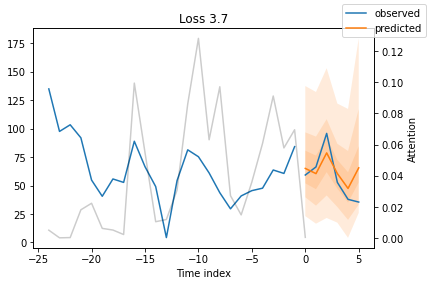

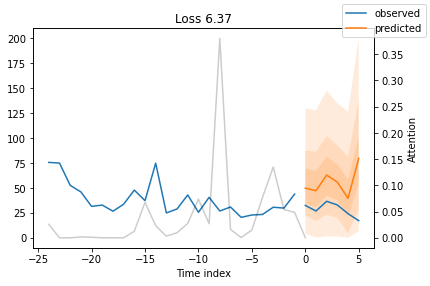

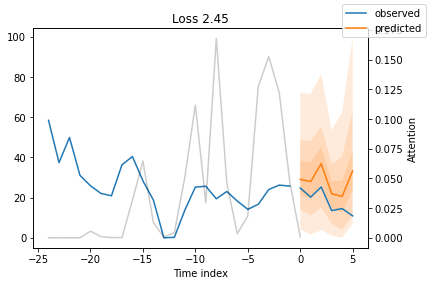

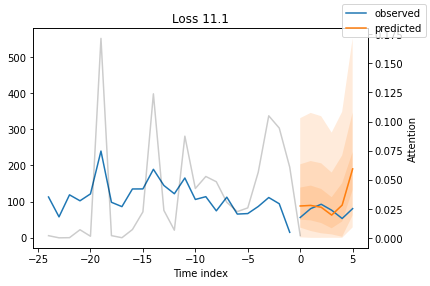

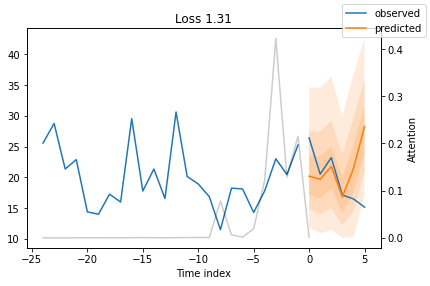

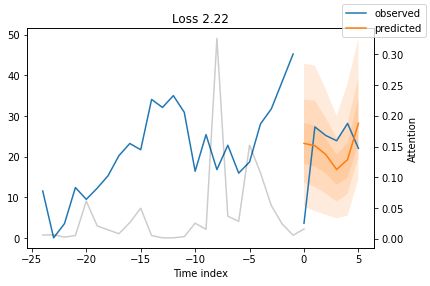

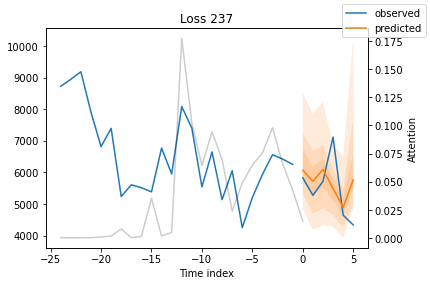

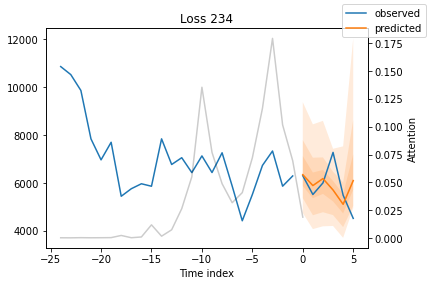

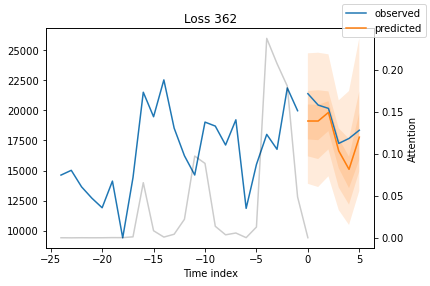

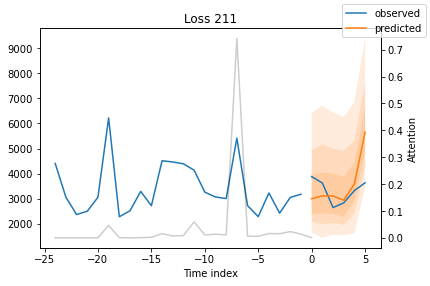

In [43]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

## Worst Performers 

#### Looking at the worst performers in terms of sMAPE gives us an idea where the model has issues with forecasting reliably

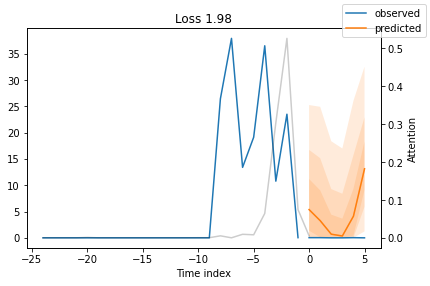

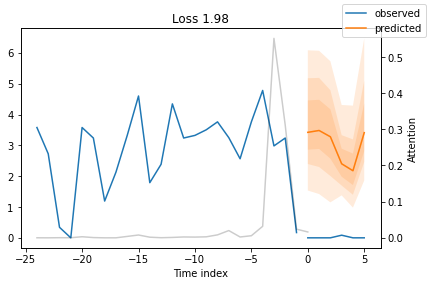

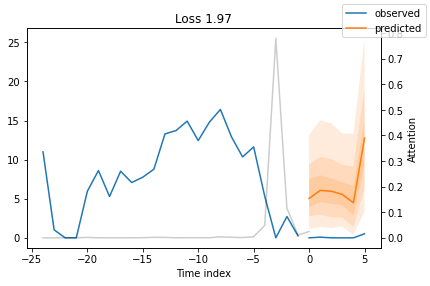

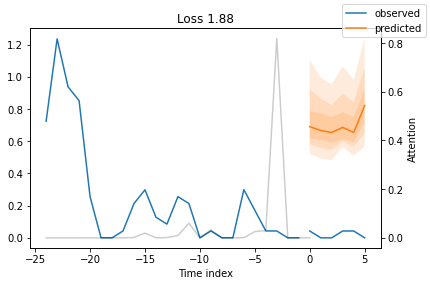

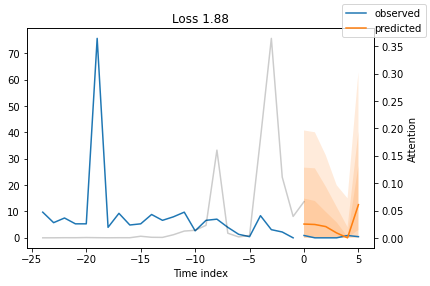

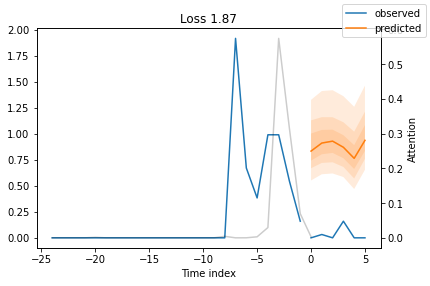

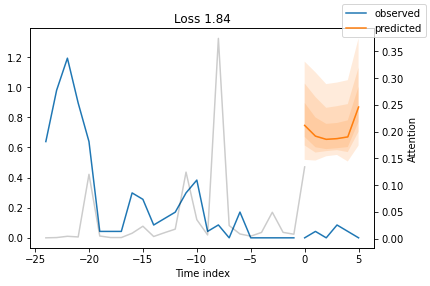

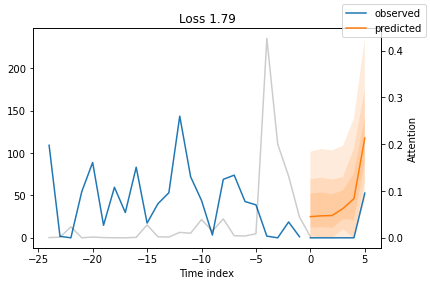

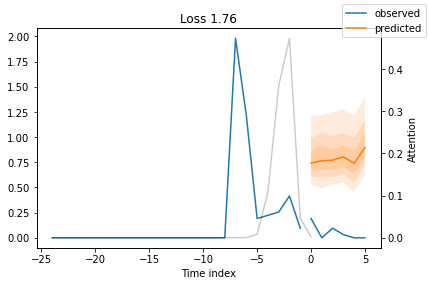

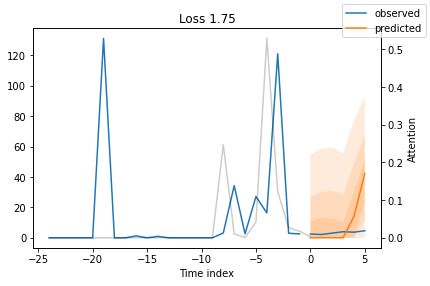

In [45]:
from pytorch_forecasting.metrics import SMAPE

# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses

# show 10 examples for demonstration purposes
for idx in range(10): # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());

## actuals vs predictions 

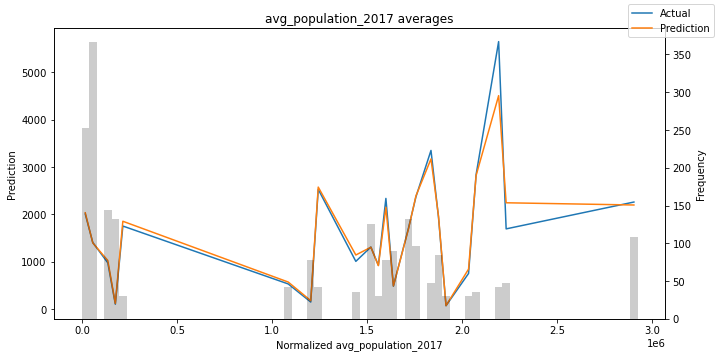

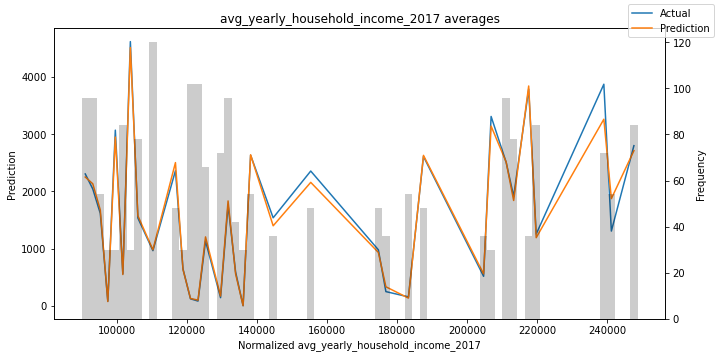

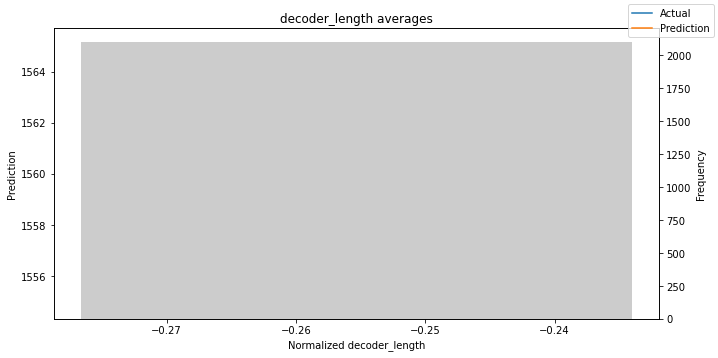

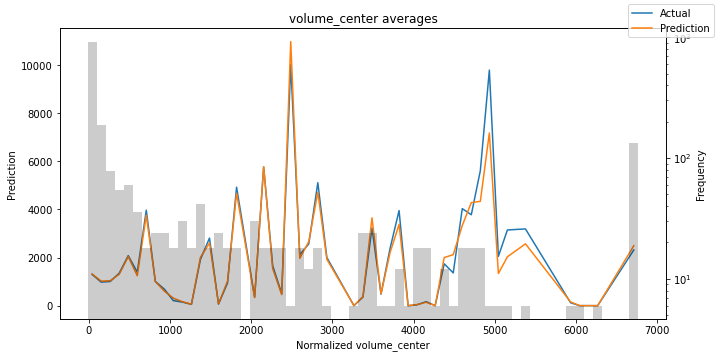

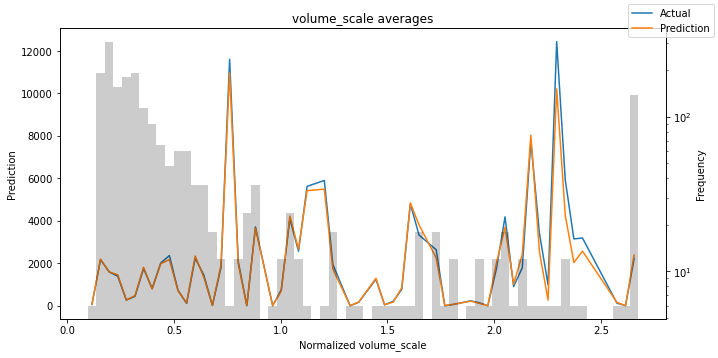

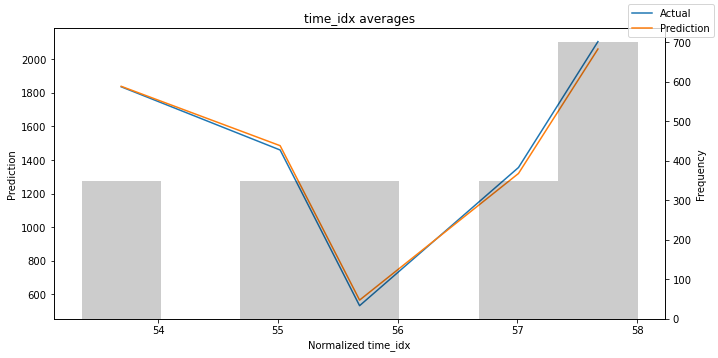

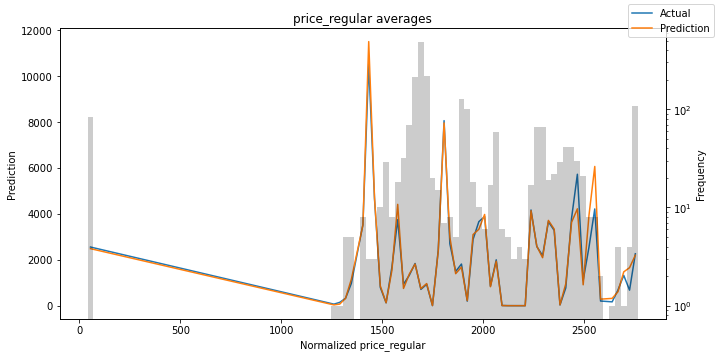

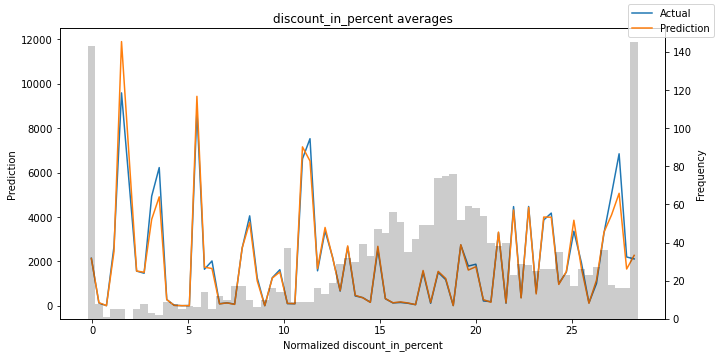

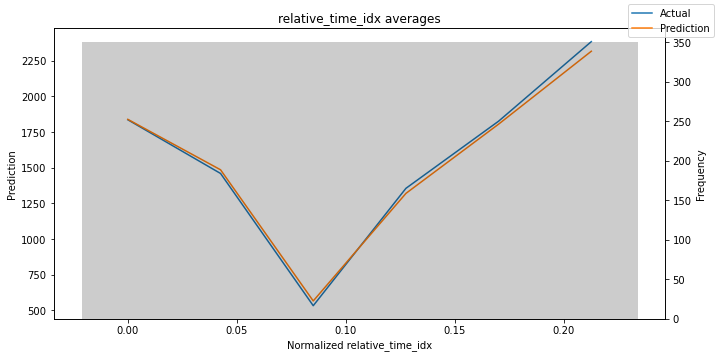

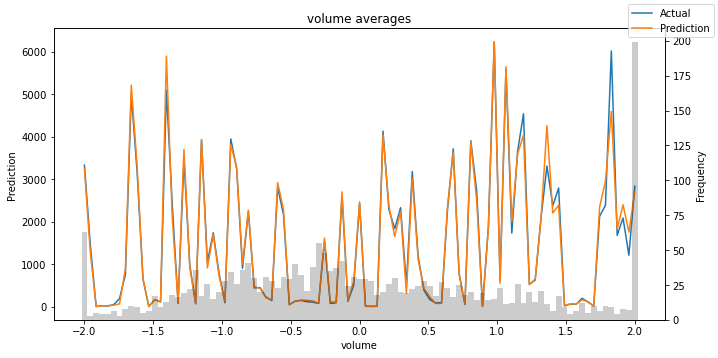

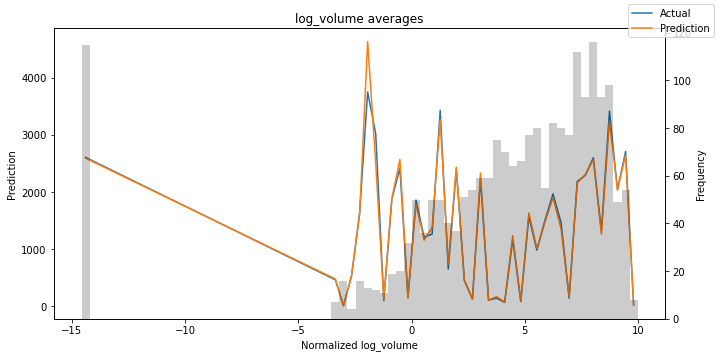

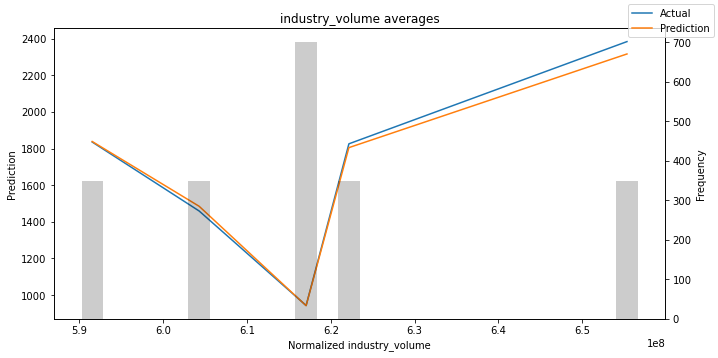

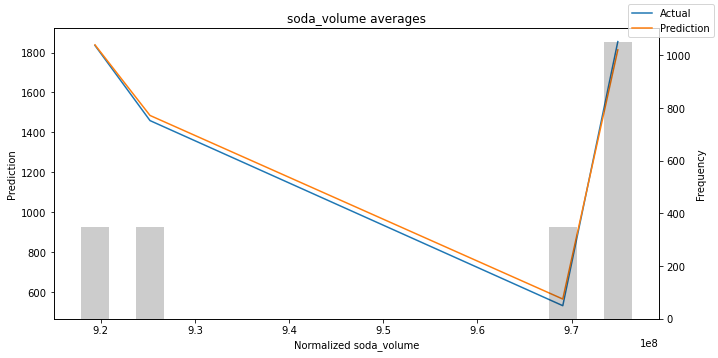

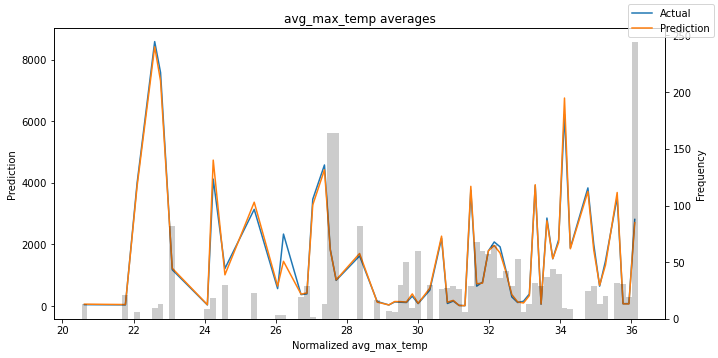

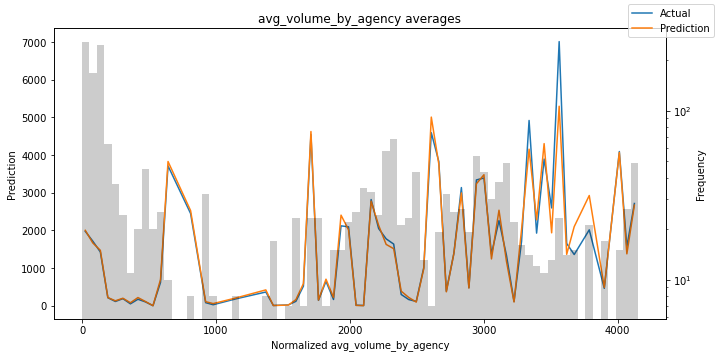

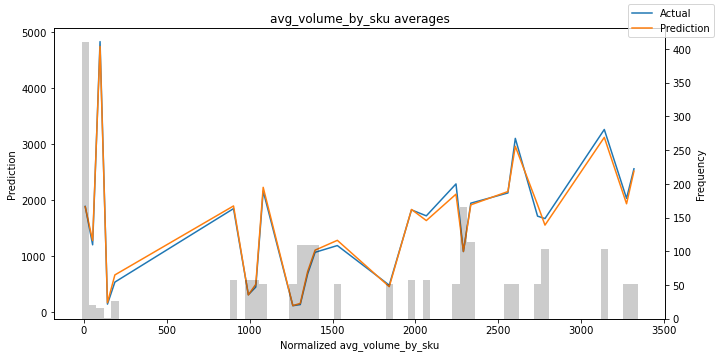

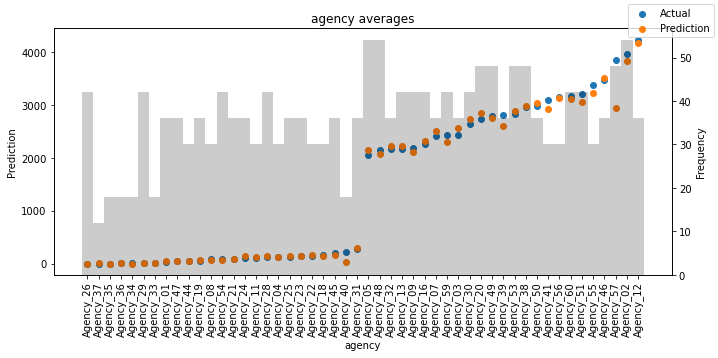

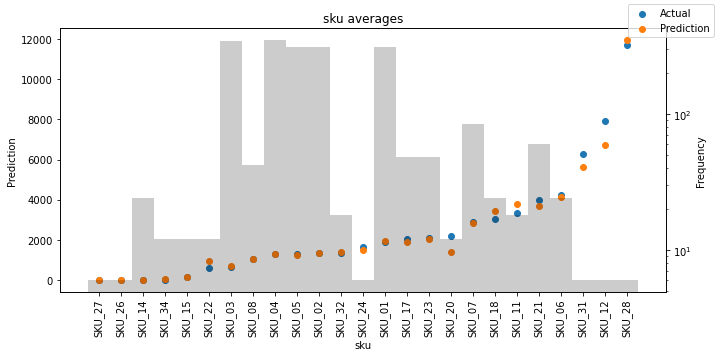

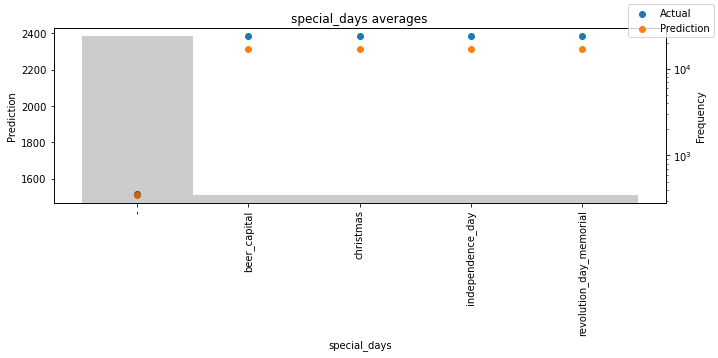

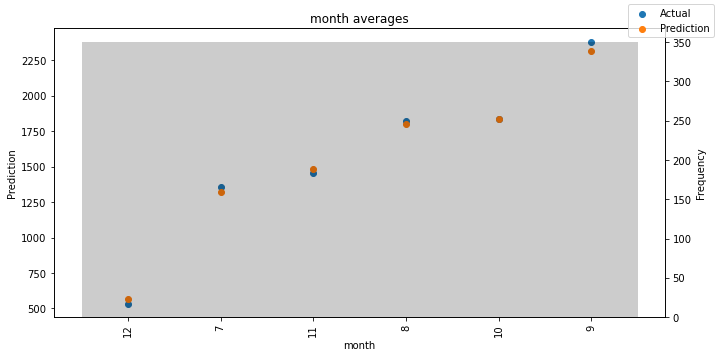

In [50]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictioans_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Interpret model 

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

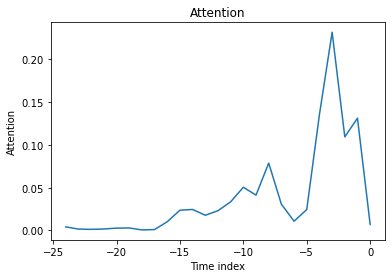

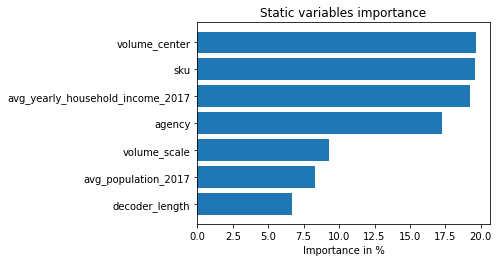

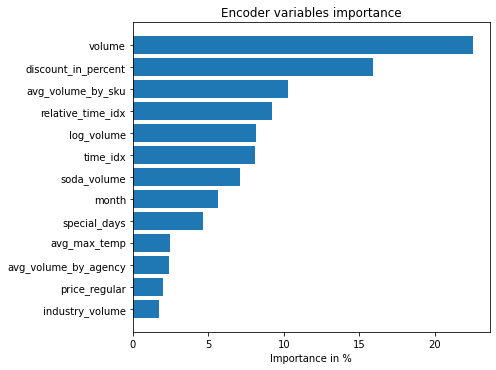

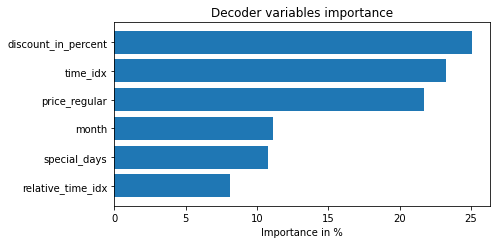

In [52]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

#### As observered, price related variables are the among the top 2 predictors for both encoder and decoder. Next, past observed volume is statistically proven to be the most important static and encoder variable.  Time related variables seem to rather lless important, this may prove that recent data are more significant than the older ones.

## Partial dependency

In [53]:
dependency = best_tft.predict_dependency(val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe")b

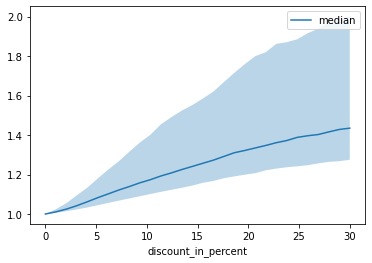

In [54]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(median="median", q25=lambda x: x.quantile(.25),  q75=lambda x: x.quantile(.75))
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=.3);


####  Interpret model better (assume independence of features) 